# Stay safe
Week 1 (1st nov - 8th Nov) : Understand the data

- Missing values
- Change the data formats
- Understand the categorical data
- Find distributions
- Correlations between the different features
- Find patterns
- Check for errors/dubious data

In [1]:
# Import libraries
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline 

import folium

from pyproj import Proj, transform

from datetime import datetime
from datetime import date, time
from dateutil.parser import parse

In [2]:
# Read the dataset
acc_data = 'Data/OTC_ACCIDENTS.csv'
compt_trafic_data = 'Data/OTC_COMPTAGE_TRAFIC.csv'
acc_df = pd.read_csv(acc_data, sep=';', encoding='latin-1')
compt_trafic_df = pd.read_csv(compt_trafic_data, sep=';', encoding='latin-1')

In [3]:
# Show the df to have a better idea
acc_df.head(3)

,ID_ACCIDENT,DATE_,GROUPE_ACCIDENT,CAUSE,COMMUNE,CONDITIONS_LUMINEUSES,CONDITIONS_METEO,CONSEQUENCES,COOR_X,COOR_Y,...,NB_MOTOS_50,NB_MOTOS_125,NB_MOTOS_11KW,NB_VOITURES_TOURISME,NB_VOITURES_LIVRAISON,NB_CAMIONS,NB_BUS,NB_TRAM,E,N
0,876245.0,2010-11-30 00:00:00,Dérapage ou perte de maîtrise,Inattention et distraction - Manque d'attentio...,Genève,Nuit,Chute de neige,Avec blessés légers,2500774.0,1117364.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,2500774.0,1117364.0
1,879408.0,2010-12-08 00:00:00,Autres,Utilisation inadéquate du véhicule - Stationne...,Genève,Jour,Beau,Autres,2498974.0,1118100.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,2498974.0,1118100.0
2,877254.0,2010-12-02 00:00:00,Dérapage ou perte de maîtrise,Inobservation de signaux ou de la signalisatio...,Vandoeuvres,Jour,Couvert,Avec blessés légers,2504618.0,1119635.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,2504618.0,1119635.0


In [4]:
# Shape of the dataset
acc_df.shape

(19231, 35)

In [5]:
# Information of the dataset
acc_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19231 entries, 0 to 19230
Data columns (total 35 columns):
ID_ACCIDENT              19231 non-null float64
DATE_                    19231 non-null object
GROUPE_ACCIDENT          19231 non-null object
CAUSE                    19231 non-null object
COMMUNE                  19231 non-null object
CONDITIONS_LUMINEUSES    19231 non-null object
CONDITIONS_METEO         19231 non-null object
CONSEQUENCES             19231 non-null object
COOR_X                   19231 non-null float64
COOR_Y                   19231 non-null float64
ETAT_ROUTE               19231 non-null object
GENRE_ROUTE              19231 non-null object
HEURE                    19230 non-null object
JOUR                     19231 non-null object
LOCALITE                 19231 non-null object
NB_ENFANTS_IMPLIQUES     19231 non-null float64
NB_ENFANTS_ECOLE         19231 non-null float64
NB_BLESSES_LEGERS        19231 non-null float64
NB_BLESSES_GRAVES        19231 non-null

The Geneva accidents dataset has 19'231 datapoints with 35 different features. They can be grouped in the following subgroups:

1) **Time**: DATE_, HEURE, JOUR

2) **Localisation**: COMMUNE, COOR_X, COOR_Y, LOCALITE, E, N 

3) **Conditions**: CONDITIONS_LUMINEUSES, CONDITIONS_METEO, ETAT_ROUTE, GENRE_ROUTE

4) **Accident type**: GROUPE_ACCIDENT, CAUSE 

5) **Number and type of people**: NB_ENFANTS_IMPLIQUES, NB_ENFANTS_ECOLE, NB_BLESSES_LEGERS, NB_BLESSES_GRAVES, NB_TUES, NB_PIETONS  

6) **Number of vehicles involved**: NB_BICYCLETTES, NB_VAE_25, NB_VAE_45, NB_CYCLOMOTEURS, NB_MOTOS_50, NB_MOTOS_125, NB_MOTOS_11KW, NB_VOITURES_TOURISME, NB_VOITURES_LIVRAISON, NB_CAMIONS, NB_BUS, NB_TRAM


### Plot helper functions

In [10]:
# Plot helper functions
def value_barplot_label(plot_name):
    # Inserts the value label on the top of each bar.

    for p in plot_name.patches:
        height = p.get_height()
        plot_name.text(p.get_x()+p.get_width()/2., height,'{:0.0f}'.format(height), ha="center").set_weight('bold')

def tick_format(plot,tick_type):
    if tick_type == 1:
        for label in plot.get_xticklabels():
            label.set_fontsize(16)
            label.set_rotation(90) 
        for label in plot.get_yticklabels():
            label.set_fontsize(14)
    
    if tick_type == 2:
        for label in plot.get_xticklabels():
            label.set_fontsize(16)
        for label in plot.get_yticklabels():
            label.set_fontsize(14)

### 1.1) Time

An important feature of the accidents datasets is the time: It answers the question when the accidents happen. This feature will be very useful for our further analysis. As time features, there are:
- Date
- Hour
- Day of the week

Let's check the format of this three features:

In [7]:
print(acc_df.DATE_.head(2))
print(acc_df.HEURE.head(2))
print(acc_df.JOUR.head(2))

0    2010-11-30 00:00:00
1    2010-12-08 00:00:00
Name: DATE_, dtype: object
0    1899-12-30 21:00:00
1    1899-12-30 14:00:00
Name: HEURE, dtype: object
0       Mardi
1    Mercredi
Name: JOUR, dtype: object


In order to use these features, we need to change the format. In addition, to enrich our analysis, we will create the `Year`, `Month` and `Day` of the month to find more correlations with the accidents:

In [8]:
# Datetime format
acc_df['DATE_'] = acc_df['DATE_'].apply(lambda d: pd.to_datetime(d))
acc_df['HEURE'] = acc_df['HEURE'].apply(lambda d: pd.to_datetime(d))

# Create new time features
acc_df['YEAR'] = [date.year for date in acc_df['DATE_']]
acc_df['MONTH'] = [date.month for date in acc_df['DATE_']]
acc_df['DAY'] = [date.day for date in acc_df['DATE_']]
acc_df['HEURE'] = acc_df['HEURE'].fillna(acc_df['HEURE'].iloc[0])  # Fillna with first value of the df (Error neglible)
#acc_df.info()

Once the time data can be treated, we start our exploratory analysis by computing:
- Number of accidents per year
- Number of accidents per month
- Number of accidents per day of the month
- Number of accidents per weekday

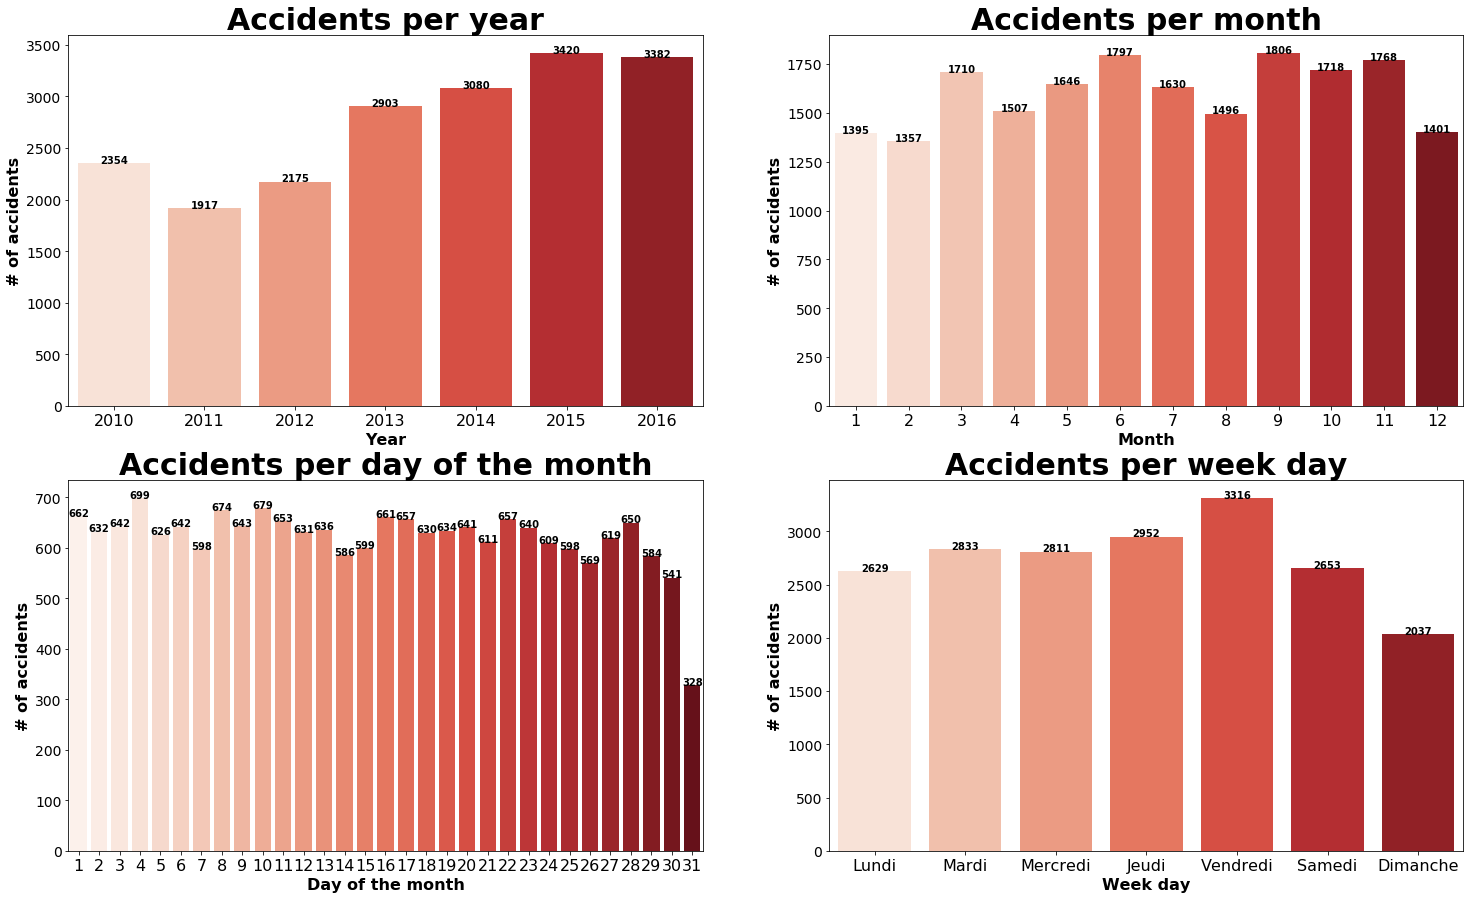

In [11]:
fig = plt.figure(figsize=(25,15))

# Visualize accidents per Year
ax1 = fig.add_subplot(221)
acc_per_year = acc_df.YEAR.value_counts(ascending=True, sort=False)
ax1 = sns.barplot(x=acc_per_year.index, 
                 y=acc_per_year, 
                 palette='Reds',
                 ax=ax1)
value_barplot_label(ax1)
plt.title("Accidents per year", fontsize=30).set_weight('bold')
tick_format(ax1, 2)
ax1.set_ylabel('# of accidents', fontsize=16).set_weight('bold')
ax1.set_xlabel('Year', fontsize=16).set_weight('bold')


# Visualize accidents per month
ax2 = fig.add_subplot(222)
acc_per_month = acc_df.MONTH.value_counts(ascending=True, sort=False)
ax2 = sns.barplot(x=acc_per_month.index, 
                 y=acc_per_month, 
                 palette='Reds',
                 ax=ax2)
value_barplot_label(ax2)
plt.title("Accidents per month", fontsize=30).set_weight('bold')
tick_format(ax2, 2)
ax2.set_ylabel('# of accidents', fontsize=16).set_weight('bold')
ax2.set_xlabel('Month', fontsize=16).set_weight('bold')

# Visualize accidents per day of the month
ax3 = fig.add_subplot(223)
acc_per_day = acc_df.DAY.value_counts(ascending=True, sort=False)
ax3 = sns.barplot(x=acc_per_day.index, 
                 y=acc_per_day, 
                 palette='Reds',
                 ax=ax3)
value_barplot_label(ax3)
plt.title("Accidents per day of the month", fontsize=30).set_weight('bold')
tick_format(ax3, 2)
ax3.set_ylabel('# of accidents', fontsize=16).set_weight('bold')
ax3.set_xlabel('Day of the month', fontsize=16).set_weight('bold')

# Visualize accidents per weekday
ax4 = fig.add_subplot(224)
weekdays=['Lundi', 'Mardi', 'Mercredi', 'Jeudi', 'Vendredi', 'Samedi', 'Dimanche']
acc_per_weekday = acc_df.JOUR.value_counts(ascending=True, sort=False).reindex(weekdays)
ax4 = sns.barplot(x=acc_per_weekday.index, 
                 y=acc_per_weekday, 
                 palette='Reds',
                 ax=ax4)
value_barplot_label(ax4)
plt.title("Accidents per week day", fontsize=30).set_weight('bold')
tick_format(ax4, 2)
ax4.set_ylabel('# of accidents', fontsize=16).set_weight('bold')
ax4.set_xlabel('Week day', fontsize=16).set_weight('bold')

From the plots above we can draw some first conclusions of the time features:
- There is an observable increase of number of accidents between 2011 to 2015. In 2016, there is a neglegible decrease.
- During the year, it can be observed some up-downs. There is a peak of accidents in March, June, September, October and November. Our first guess is that during the months when it is the holidays start or the end of the year months, it is more probable to have an accident. A further analysis could be done in order to verify the first assumption by getting the information of the year holidays and seeing the correlation with the accidents dates. (**TO DEVELOP**).
- During the month, there is no appreciable correlation within the day of the month and the probability to have an accident
- However, during the week, the days with higher probability to have an accident are Thurstday and Friday. A further analysis can be to see if there is an increase of this tendency during the years (**TO DEVELOP**)

### 1.2) Localisation

An other important question to ask is WHERE?. The localisation features will help to answer this question and find the relation with the other features. 
As localisation features, we can find:
- **COOR_X**: X coordenate in 'epsg_2056' reference system
- **COOR_Y**: X coordenate in 'epsg_2056' reference system

E and N gives the same information as COOR_X and COOR_Y. This is why they will be dropped. The COOR_X and COOR_Y coordenates will be projected in the GPS coordenates, also called 'epsg:4326' reference system. For this, the Proj and transform libraries will be used:

In [12]:
# projection definition
p1 = Proj(init='epsg:2056')
p2 = Proj(init='epsg:4326')

# Helper functions
def coord_proj(acc_df,i, p1, p2):
    x1 = acc_df['COOR_X'].loc[i]
    y1 = acc_df['COOR_Y'].loc[i]
    x2, y2 = transform(p1,p2,x1,y1)
    acc_df['COOR_X'].set_value(i, x2)
    acc_df['COOR_Y'].set_value(i, y2)
    return acc_df

In [14]:
# Project data
for i in range(0, len(acc_df['COOR_X'])-1):
    acc_df = coord_proj(acc_df,i, p1, p2)
# Delete unuseful columns
#del acc_df['N']
#del acc_df['E']
acc_df.head(3)

,ID_ACCIDENT,DATE_,GROUPE_ACCIDENT,CAUSE,COMMUNE,CONDITIONS_LUMINEUSES,CONDITIONS_METEO,CONSEQUENCES,COOR_X,COOR_Y,...,NB_MOTOS_125,NB_MOTOS_11KW,NB_VOITURES_TOURISME,NB_VOITURES_LIVRAISON,NB_CAMIONS,NB_BUS,NB_TRAM,YEAR,MONTH,DAY
0,876245.0,2010-11-30,Dérapage ou perte de maîtrise,Inattention et distraction - Manque d'attentio...,Genève,Nuit,Chute de neige,Avec blessés légers,6.153116,46.200401,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,2010,11,30
1,879408.0,2010-12-08,Autres,Utilisation inadéquate du véhicule - Stationne...,Genève,Jour,Beau,Autres,6.129641,46.206753,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,2010,12,8
2,877254.0,2010-12-02,Dérapage ou perte de maîtrise,Inobservation de signaux ou de la signalisatio...,Vandoeuvres,Jour,Couvert,Avec blessés légers,6.202445,46.221384,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,2010,12,2


An other localisation feature is the "Commune". In order more information to get insight of the accidents dataset, it will be interesting to have the number of inhabitants of each Commune (**TO Develop**)

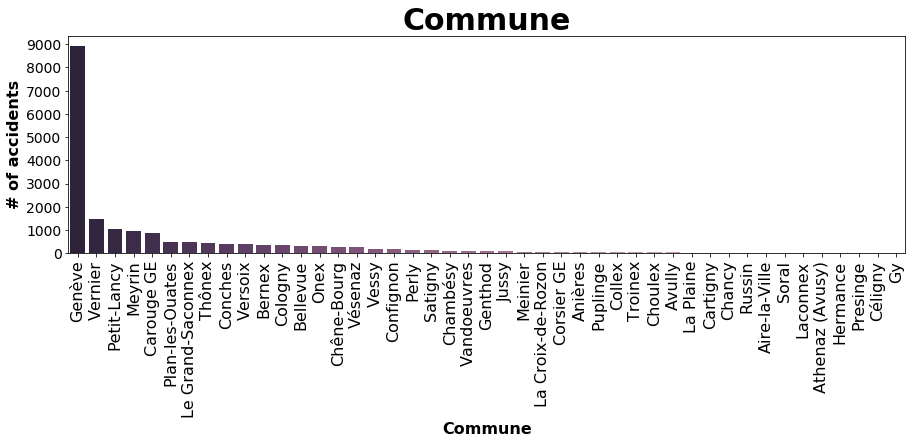

In [27]:

plt.figure(figsize=(15,4))
commune_accidents = acc_df.COMMUNE.value_counts()
ax = sns.barplot(x=commune_accidents.index, 
                 y=commune_accidents, 
                 palette=sns.cubehelix_palette(reverse=True, n_colors=len(commune_accidents.index)))
ax.set(yticks=np.linspace(0,9000,num=10))
plt.title("Commune", fontsize=30).set_weight('bold')
tick_format(ax, 1)
ax.set_ylabel('# of accidents', fontsize=16).set_weight('bold')
ax.set_xlabel('Commune', fontsize=16).set_weight('bold')

In [26]:
acc_df.LOCALITE.value_counts()

A l'intérieur d'une localité    10789
Non renseigné                    6101
A l'extérieur d'une localité     2341
Name: LOCALITE, dtype: int64

### 1.1) Accident type

In the accident type features, it can be found:
- Accident group
- Causes

Let's start analysing the accident group.

In [ ]:
plt.figure(figsize=(15,10))
groupe_accidents = acc_df.GROUPE_ACCIDENT.value_counts()
ax = sns.barplot(x=groupe_accidents, 
                 y=groupe_accidents.index, 
                 palette=sns.cubehelix_palette(reverse=True, n_colors=len(groupe_accidents.index)))
ax.set(xticks=np.linspace(0,5500,num=12))
#value_barplot_label(ax)
plt.title("Accident Group", fontsize=30).set_weight('bold')
tick_format(ax, 1)
ax.set_ylabel('Accident group', fontsize=16).set_weight('bold')
ax.set_xlabel('# of accidents', fontsize=16).set_weight('bold')

By the figure above, it can be identified that the accident groups with more accidents are:
- Dérapage ou perte de maîtrise
- Accident par tamponnement
- Accident en parquant

In [ ]:
# Create a new df to treat the causes column
causes = acc_df[['CAUSE', 'GROUPE_ACCIDENT']]
causes['count_'] = causes.CAUSE.apply(lambda x: x.count(' - '))
del causes['GROUPE_ACCIDENT']

# Goal: To have only one "-" in order to split the causes into two columns, group and sugroup of causes
conflictive_txt = "(confusion frein - accélérateur, glisser de la pédale de frein dans les véhicules à transmission automatique, etc.)"
causes.CAUSE = causes.CAUSE.str.replace(conflictive_txt, "")
causes['count_'] = causes.CAUSE.apply(lambda x: x.count(' - '))
causes = causes.CAUSE.str.split(' - ', expand=True)
causes.rename(columns ={0: 'CAUSE_g', 1: 'CAUSE_sg'}, inplace=True)
acc_new = pd.concat([acc_df, causes], axis=1)
del acc_new['CAUSE']
acc_new.head(5)

Utilisation inadéquate du véhicule
    - Manoeuvres incorrectes dans le véhicule ():
        -(confusion frein - accélérateur, glisser de la pédale de frein dans les véhicules à transmission automatique, etc.)

In [ ]:
# Create the map visualization
Geneve_coord = [46.2004013, 6.1531163]
m = folium.Map(location=Geneve_coord, zoom_start=13)

In [ ]:
for i in range(0, len(acc_df['COOR_X'].head(10))):
    print([acc_df.COOR_X.loc[i], acc_df.COOR_Y.loc[i]])
    folium.Marker([acc_df.COOR_Y.loc[i], acc_df.COOR_X.loc[i]] , popup="1").add_to(m)
m

Ideas:
* For each accident zone personalize the information panels